In [36]:
!pip install geopandas rasterio shapely fiona pyproj rtree
!pip install rioxarray rasterstats

# Cargar librerías

import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import rasterstats
import warnings
warnings.filterwarnings('ignore')


In [13]:

# Cargamos límites distritales del INEI
shp_path = r"C:\Users\richa\Documents\GitHub\Minimum-Temperature-Raster\data\INEI-DISTRITAL\INEI_LIMITE_DISTRITAL.shp"
boundaries = gpd.read_file(shp_path)


In [14]:
# Para ver cómo cambian los nombres previos, elegimos las columnas más relevantes para este trabajo

for col in ["NOMBDEP", "NOMBPROV", "NOMBDIST", "UBIGEO"]:
    if col in boundaries.columns:
        boundaries[f"{col}_ANTES"] = boundaries[col]

        
#aquí, ya pareciera que los nombres están bien. Igual se normalizará para asegurar ello. 

In [15]:

# Aquí normalizamos el texto: convertir a mayúsculas y eliminar tildes/diacríticos
def normalize_text(x):
    if pd.isna(x):
        return x
    x = str(x).strip().upper()
    x = unicodedata.normalize("NFD", x)
    x = "".join([c for c in x if unicodedata.category(c) != "Mn"])
    return x

# Aplica la función a todas las columnas tipo texto (por si hay nombres o UBIGEO)
for col in boundaries.columns:
    if boundaries[col].dtype == "object":
        boundaries[col] = boundaries[col].apply(normalize_text)

print(" Shapefile cargado correctamente")
print("Columnas disponibles:", list(boundaries.columns))


 Shapefile cargado correctamente
Columnas disponibles: ['CCDD', 'NOMBDEP', 'CCPP', 'NOMBPROV', 'CCDI', 'NOMBDIST', 'CAPITAL', 'UBIGEO', 'IDPROV', 'CODIGO', 'CNT_CCPP', 'DESCRIPCIO', 'DESCARGAR', 'WHATSAPP', 'CONTACTO', 'geometry', 'NOMBDEP_ANTES', 'NOMBPROV_ANTES', 'NOMBDIST_ANTES', 'UBIGEO_ANTES']


In [16]:
# Aquí quiero ver cómo ha cambiado, y se ve que no han habido cambios. Es decir, la base de datos ya estaba en orden.
def comparar_cambios(df, col):
    antes = f"{col}_ANTES"
    despues = col
    dif = df[df[antes] != df[despues]][[antes, despues]]
    print(f"\n🔍 Cambios detectados en {col}: {len(dif)}")
    if len(dif) > 0:
        print(dif.head(10))
    return dif

cambios_dep = comparar_cambios(boundaries, "NOMBDEP")
cambios_prov = comparar_cambios(boundaries, "NOMBPROV")
cambios_dist = comparar_cambios(boundaries, "NOMBDIST")

# Verifico si UBIGEO se mantuvo intacto
ubigeo_diff = boundaries[boundaries["UBIGEO_ANTES"] != boundaries["UBIGEO"]]
print(f"\n Cambios detectados en UBIGEO: {len(ubigeo_diff)}")
if len(ubigeo_diff) > 0:
    print(ubigeo_diff[["UBIGEO_ANTES", "UBIGEO"]].head(10))


🔍 Cambios detectados en NOMBDEP: 0

🔍 Cambios detectados en NOMBPROV: 0

🔍 Cambios detectados en NOMBDIST: 0

 Cambios detectados en UBIGEO: 0


In [18]:
# Ahora cargo raster Tmin (GeoTIFF)
raster_path = r"C:\Users\richa\Documents\GitHub\Minimum-Temperature-Raster\data\tmin_raster.tif"
raster = rasterio.open(raster_path)

print("Raster cargado correctamente")
print("Número de bandas:", raster.count)
print("Dimensiones:", raster.width, "x", raster.height)
print("CRS:", raster.crs)

Raster cargado correctamente
Número de bandas: 5
Dimensiones: 285 x 397
CRS: EPSG:4326


Procesando banda 1...


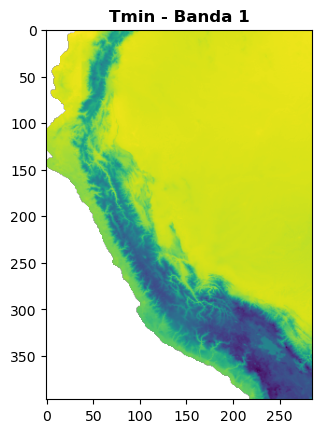

Procesando banda 2...


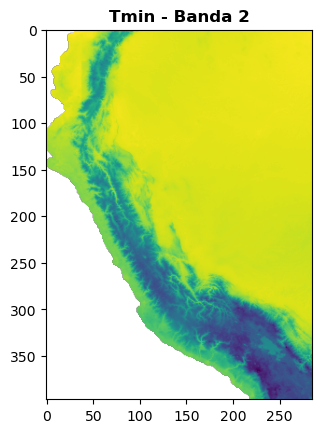

Procesando banda 3...


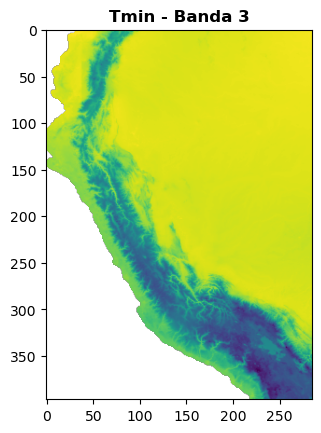

Procesando banda 4...


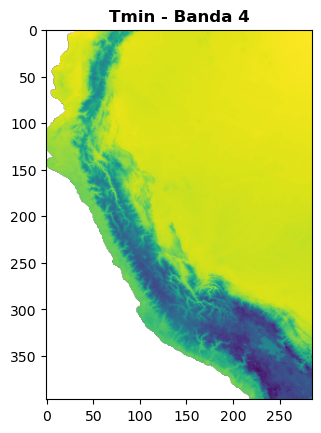

Procesando banda 5...


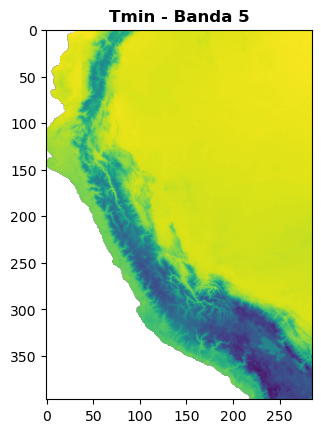

In [19]:
# El raster tiene varias bandas (por meses o años), entonces las recorremos
for i in range(1, raster.count + 1):
    band_data = raster.read(i)
    print(f"Procesando banda {i}...")
    show(band_data, title=f"Tmin - Banda {i}")

In [20]:
# Voy a validar que geometrías son válidas
print(boundaries.is_valid.value_counts())
boundaries = boundaries[boundaries.is_valid]


True    1874
Name: count, dtype: int64


In [21]:
# También, voy a ver que coincida
print("CRS límites:", boundaries.crs)
print("CRS raster:", raster.crs)


CRS límites: EPSG:4326
CRS raster: EPSG:4326


In [22]:
#Ahora revisamos extensión espacial (bounds) 
print("\n🗺️ Extensión del shapefile:", boundaries.total_bounds)
print("🗺️ Extensión del raster:", raster.bounds)

# Se comprueba si se superponen
from shapely.geometry import box

bbox_vector = box(*boundaries.total_bounds)
bbox_raster = box(*raster.bounds)

if bbox_vector.intersects(bbox_raster):
    print("El shapefile y el raster se superponen correctamente")
else:
    print("No se superponen: revisa si están en zonas distintas o CRS distintos.")

# Se revisa resolución del raster 
print("\n📏 Resolución del raster (tamaño de píxel):", raster.res)

# Todos los resultados muestran que todo está alineado entre el shapefile distrital y el raster


🗺️ Extensión del shapefile: [-8.13282305e+01 -1.83509277e+01 -6.86522791e+01 -3.86059690e-02]
🗺️ Extensión del raster: BoundingBox(left=-81.38, bottom=-18.65000000000002, right=-67.1300000000008, top=1.2000000000000002)
El shapefile y el raster se superponen correctamente

📏 Resolución del raster (tamaño de píxel): (0.04999999999999716, 0.050000000000000044)


## Zonal stats

In [42]:
# Zonal stats (at least: mean, min, max, std, p10, p90) + one custom metric.
shp_path = r"C:\Users\richa\Documents\GitHub\Minimum-Temperature-Raster\data\INEI-DISTRITAL\INEI_LIMITE_DISTRITAL.shp"
boundaries = gpd.read_file(shp_path)
raster_path = r"C:\Users\richa\Documents\GitHub\Minimum-Temperature-Raster\data\tmin_raster.tif"
raster = rasterio.open(raster_path)


if boundaries.crs != raster.crs:
    boundaries = boundaries.to_crs(raster.crs)

print(f"✓ Datos cargados: {len(boundaries)} distritos")


stats = zonal_stats(boundaries, raster_path, 
                    stats=['mean', 'min', 'max', 'std', 'median'],
                    percentile=[10, 90],
                    add_stats={'rango': lambda x: np.max(x) - np.min(x)})

df = pd.DataFrame(stats)

# Verificar columnas generadas y renombrar
print(f"Columnas generadas: {list(df.columns)}")

# Renombrar solo las columnas que existen
if 'mean' in df.columns:
    df = df.rename(columns={
        'mean': 'Temp_Media',
        'min': 'Temp_Min', 
        'max': 'Temp_Max',
        'std': 'Temp_Desv',
        'median': 'Temp_Mediana',
        'percentile_10': 'P10',
        'percentile_90': 'P90',
        'rango': 'Rango'
    })

# Agregar columnas de ubicación
df.insert(0, 'DISTRITO', boundaries['NOMBDIST'].values)
df.insert(1, 'PROVINCIA', boundaries['NOMBPROV'].values)
df.insert(2, 'DEPARTAMENTO', boundaries['NOMBDEP'].values)

gdf = gpd.GeoDataFrame(df, geometry=boundaries.geometry, crs=boundaries.crs)

print(f"✓ Estadísticas calculadas\n{df[['Temp_Media', 'Temp_Min', 'Temp_Max']].describe()}")

✓ Datos cargados: 1874 distritos
Columnas generadas: ['min', 'max', 'mean', 'std', 'median', 'rango']
✓ Estadísticas calculadas
        Temp_Media     Temp_Min     Temp_Max
count  1790.000000  1790.000000  1790.000000
mean      9.645885     7.406829    11.861696
std       7.004712     7.331077     6.685677
min      -5.241692    -8.782926    -3.204630
25%       4.009272     1.836247     6.128598
50%       8.569635     5.450457    11.617040
75%      15.450253    12.712108    17.793315
max      23.294387    22.989103    23.911810


In [43]:
df.to_csv('estadisticas_completas.csv', index=False, encoding='utf-8-sig')
df.nsmallest(20, 'Temp_Media').to_csv('top20_mas_frios.csv', index=False, encoding='utf-8-sig')
print("✓ CSVs exportados")


✓ CSVs exportados


✓ Gráfico 1 guardado


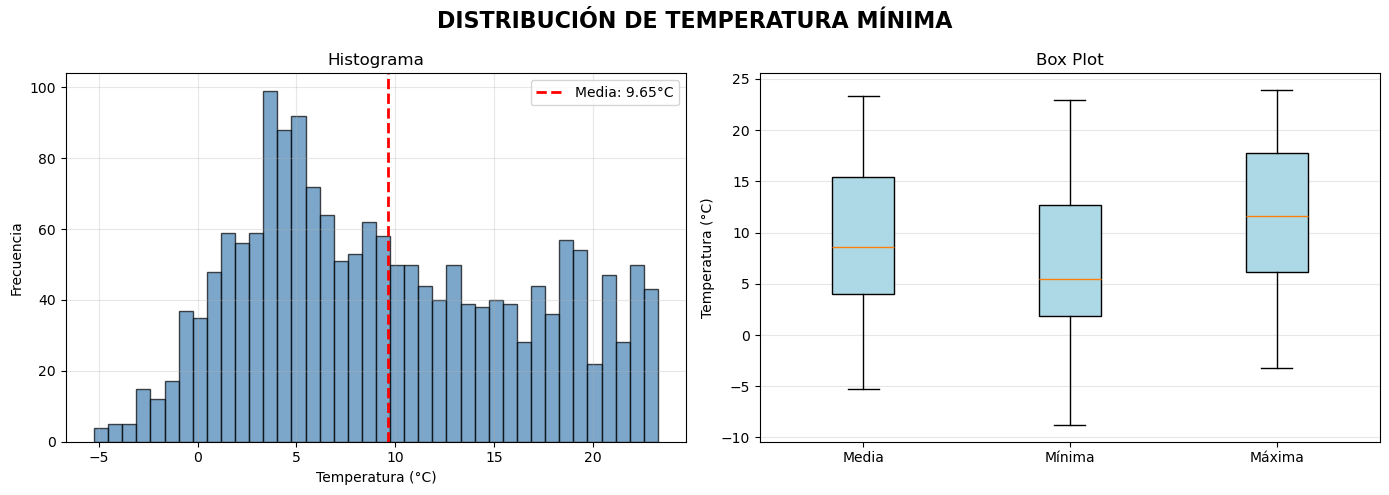

In [45]:
# At least 3 plots: distribution, ranking, and a static map.
# ========== GRÁFICO 1: DISTRIBUCIÓN ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('DISTRIBUCIÓN DE TEMPERATURA MÍNIMA', fontsize=16, fontweight='bold')

# Limpiar datos para el histograma
temp_media_limpia = df['Temp_Media'].dropna()
axes[0].hist(temp_media_limpia, bins=40, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(temp_media_limpia.mean(), color='red', linestyle='--', linewidth=2, 
                label=f"Media: {temp_media_limpia.mean():.2f}°C")
axes[0].set_xlabel('Temperatura (°C)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Histograma')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Limpiar datos para boxplot (eliminar NaN)
datos_box = [df['Temp_Media'].dropna(), 
             df['Temp_Min'].dropna(), 
             df['Temp_Max'].dropna()]
bp = axes[1].boxplot(datos_box, 
                     labels=['Media', 'Mínima', 'Máxima'],
                     patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[1].set_ylabel('Temperatura (°C)')
axes[1].set_title('Box Plot')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('01_distribucion.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico 1 guardado")
plt.show()


✓ Gráfico 2 guardado


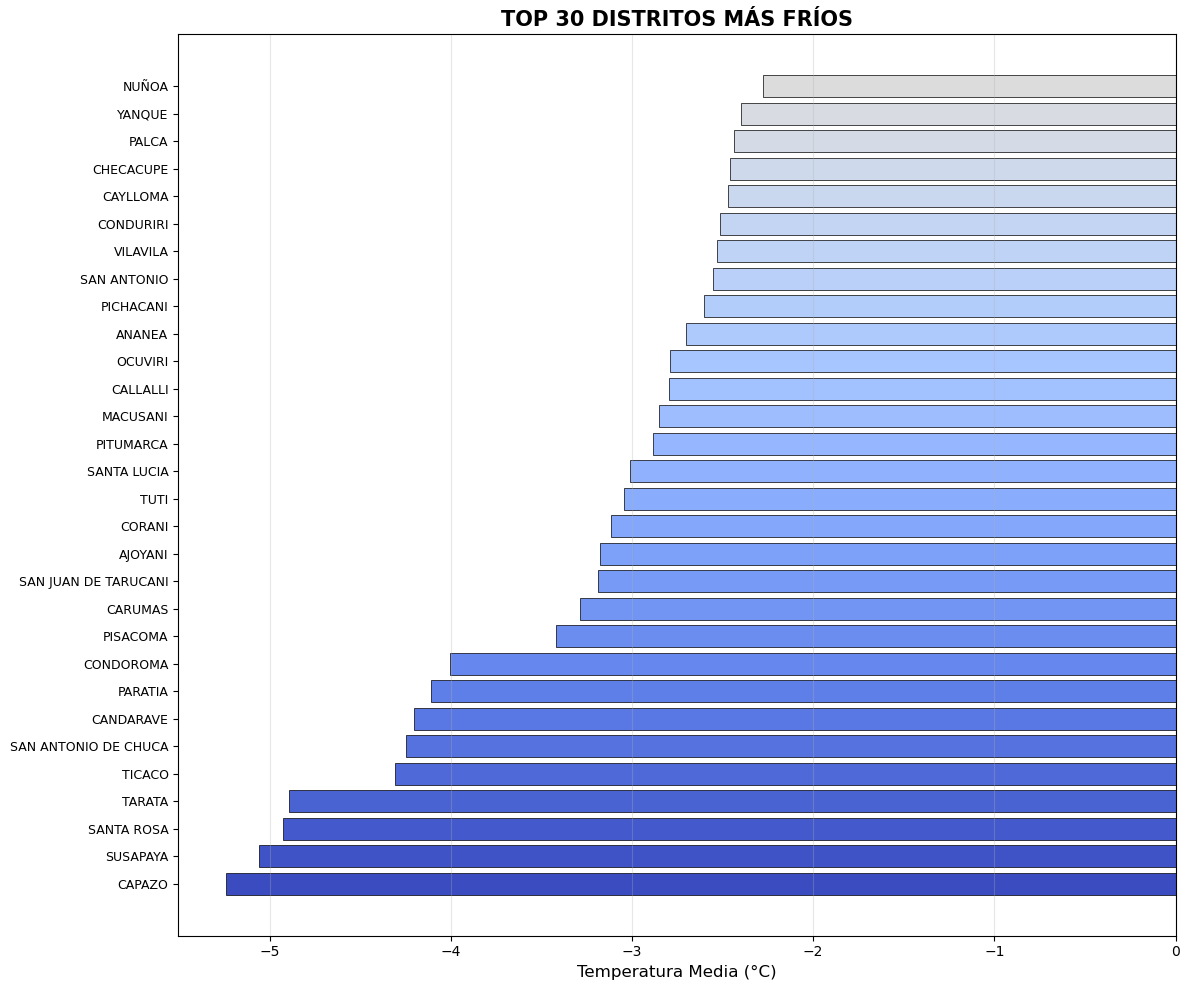

In [51]:
# ========== GRÁFICO 2: RANKING ==========
fig, ax = plt.subplots(figsize=(12, 10))
top30 = df.nsmallest(30, 'Temp_Media').sort_values('Temp_Media')

colors = plt.cm.coolwarm(np.linspace(0, 0.5, len(top30)))
ax.barh(range(len(top30)), top30['Temp_Media'], color=colors, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top30)))
ax.set_yticklabels([f"{row['DISTRITO']}" for _, row in top30.iterrows()], fontsize=9)
ax.set_xlabel('Temperatura Media (°C)', fontsize=12)
ax.set_title('TOP 30 DISTRITOS MÁS FRÍOS', fontsize=15, fontweight='bold')
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('02_ranking.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico 2 guardado")
plt.show()

✓ Gráfico 3 guardado


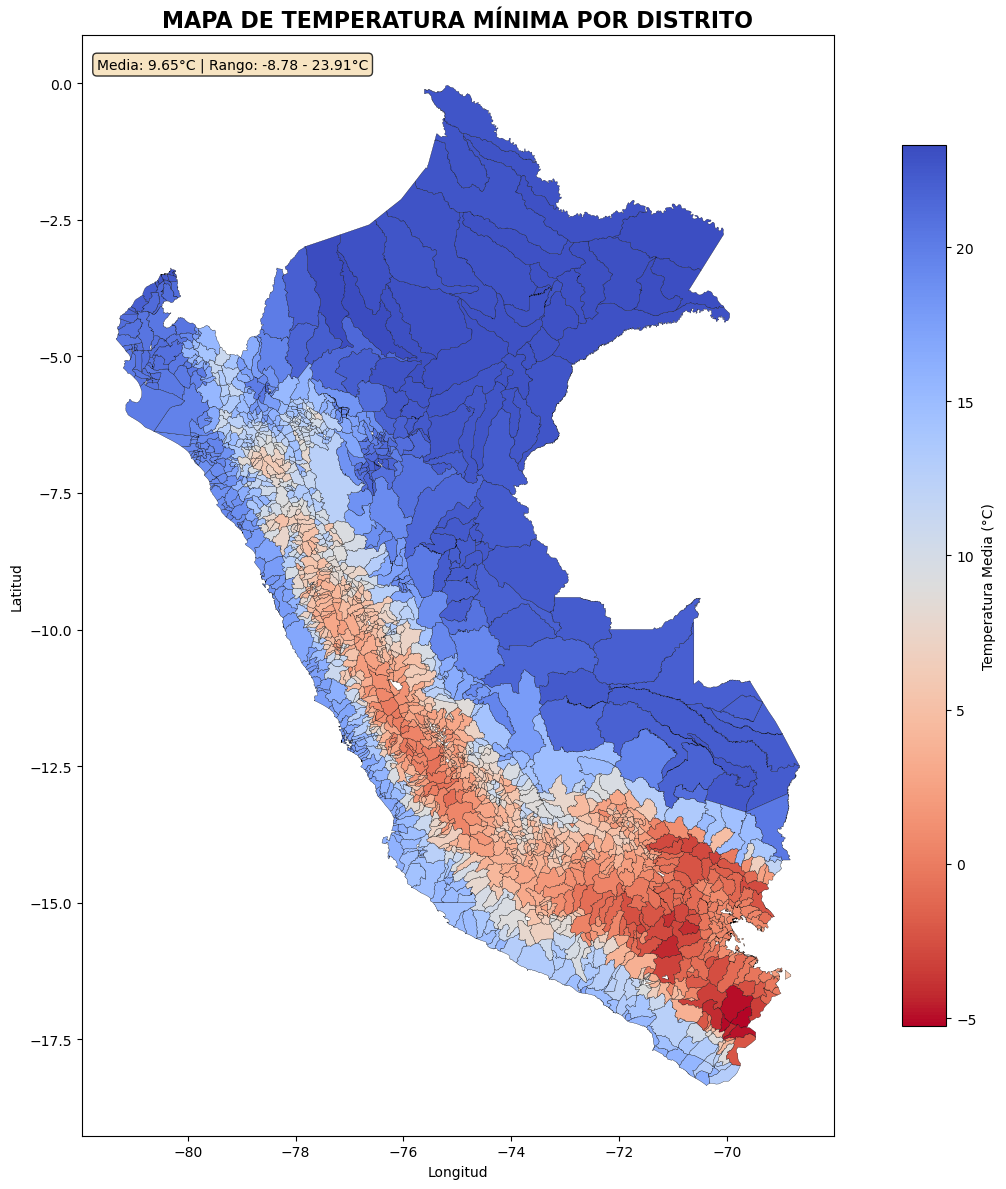

In [52]:
# ========== GRÁFICO 3: MAPA ==========
fig, ax = plt.subplots(figsize=(14, 12))
gdf.plot(column='Temp_Media', cmap='coolwarm_r', legend=True, ax=ax,
         edgecolor='black', linewidth=0.2,
         legend_kwds={'label': "Temperatura Media (°C)", 'shrink': 0.8})
ax.set_title('MAPA DE TEMPERATURA MÍNIMA POR DISTRITO', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

textstr = f'Media: {df["Temp_Media"].mean():.2f}°C | Rango: {df["Temp_Min"].min():.2f} - {df["Temp_Max"].max():.2f}°C'
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('03_mapa.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico 3 guardado")
plt.show()

In [54]:
# Public Policy section: diagnosis + 3 prioritized measures (target population/territory, estimated budget, KPIs).
# ========== POLÍTICA PÚBLICA ==========
umbral = df['Temp_Media'].quantile(0.10)
vulnerables = df[df['Temp_Media'] < umbral]

print(f"\n{'='*60}")
print("ANÁLISIS DE POLÍTICA PÚBLICA")
print(f"{'='*60}")
print(f"\n DIAGNÓSTICO:")
print(f"   • Distritos vulnerables: {len(vulnerables)} ({len(vulnerables)/len(df)*100:.1f}%)")
print(f"   • Temperatura umbral: < {umbral:.2f}°C")
print(f"   • Distrito más frío: {df.loc[df['Temp_Media'].idxmin(), 'DISTRITO']} ({df['Temp_Media'].min():.2f}°C)")

medidas = pd.DataFrame({
    'Medida': ['Programa Abrigo y Calefacción', 'Sistema Alerta Temprana', 'Infraestructura Térmica'],
    'Población_Objetivo': [f'{len(vulnerables)} distritos', 'Distritos T<10°C', 'Top 50 más fríos'],
    'Presupuesto_Estimado': ['S/ 15M', 'S/ 3.5M', 'S/ 25M'],
    'KPI': ['↓30% enfermedades respiratorias', '95% alertas en 24h', '80% viviendas aisladas']
})

medidas.to_csv('06_medidas_politica.csv', index=False, encoding='utf-8-sig')
vulnerables[['DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'Temp_Media']].to_csv(
    '07_distritos_prioritarios.csv', index=False, encoding='utf-8-sig')
print("✓ 06_medidas_politica.csv - 3 medidas prioritarias con KPIs")
print("✓ 07_distritos_prioritarios.csv - Lista de distritos vulnerables")

print(f"\n 3 MEDIDAS PRIORITARIAS:")
for i, row in medidas.iterrows():
    print(f"\n{i+1}. {row['Medida']}")
    print(f"   └─ Objetivo: {row['Población_Objetivo']}")
    print(f"   └─ Presupuesto: {row['Presupuesto_Estimado']}")
    print(f"   └─ KPI: {row['KPI']}")

print(f"\n{'='*60}")
print("ANÁLISIS COMPLETO")
print(f"{'='*60}")
print("\n Archivos generados:")
print("   • 3 Gráficos PNG (distribución, ranking, mapa)")
print("   • 7 Tablas CSV descargables:")
print("     - 01: Estadísticas completas por distrito")
print("     - 02: Top 20 más fríos")
print("     - 03: Top 20 más cálidos")
print("     - 04: Resumen por departamento")
print("     - 05: Resumen por provincia")
print("     - 06: Medidas de política pública")
print("     - 07: Distritos prioritarios")
print(f"{'='*60}")


ANÁLISIS DE POLÍTICA PÚBLICA

 DIAGNÓSTICO:
   • Distritos vulnerables: 179 (9.6%)
   • Temperatura umbral: < 1.21°C
   • Distrito más frío: CAPAZO (-5.24°C)
✓ 06_medidas_politica.csv - 3 medidas prioritarias con KPIs
✓ 07_distritos_prioritarios.csv - Lista de distritos vulnerables

 3 MEDIDAS PRIORITARIAS:

1. Programa Abrigo y Calefacción
   └─ Objetivo: 179 distritos
   └─ Presupuesto: S/ 15M
   └─ KPI: ↓30% enfermedades respiratorias

2. Sistema Alerta Temprana
   └─ Objetivo: Distritos T<10°C
   └─ Presupuesto: S/ 3.5M
   └─ KPI: 95% alertas en 24h

3. Infraestructura Térmica
   └─ Objetivo: Top 50 más fríos
   └─ Presupuesto: S/ 25M
   └─ KPI: 80% viviendas aisladas

ANÁLISIS COMPLETO

 Archivos generados:
   • 3 Gráficos PNG (distribución, ranking, mapa)
   • 7 Tablas CSV descargables:
     - 01: Estadísticas completas por distrito
     - 02: Top 20 más fríos
     - 03: Top 20 más cálidos
     - 04: Resumen por departamento
     - 05: Resumen por provincia
     - 06: Medidas de